In [2]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from math import pi,cos,sin
import random

In [134]:
NP = 1   # Number of polymers
N  = 250 # Number of monomers per polymer
NA = 20   # Number of angles
epsilon = 0.28
sigma = 0.8
T  = 1
kb = 1
b  = 1/(kb*T)

In [135]:
def getweight(NA, cn):
    
    # We create NA  coordinates distributed evenly on a unit circle.
    angle = np.zeros((NA,2),dtype='float')
    maxangle = 2*pi/NA
    rndangle = maxangle*random.random()                                 #random phase shift.
    angle[:, 0] = np.cos(rndangle + maxangle*np.linspace(0, NA-1, NA))  # X coordinate.
    angle[:, 1] = np.sin(rndangle + maxangle*np.linspace(0, NA-1, NA))  # Y coordinate.
    
    # We calculate the weights for each angle.
    weight = np.zeros((NA,1),dtype='float')
    for i in range(NA):
        # Array of squared distance to all prior monomers except the previous (always at distance 1):
        r2 = (pos[cn-1, 0] + angle[i, 0] - pos[0:(cn-1), 0])**2 + (pos[cn-1, 1] + angle[i, 1] - pos[0:(cn-1), 1])**2 
        E = sum(4*epsilon*((sigma**2/r2)**6 - (sigma**2/r2)**3)) # Leonard-Jones potential for current angle due to all other monomers.
        weight[i] = np.exp(-E*b)                       
    
    return weight, angle

In [136]:
def R_Extend(cn):
    
    succes = 0                  
    errorcounter = 0
    while succes == 0:
        
        weight, angle = getweight(NA, cn)

        # Sometimes all angles result in 0 weight, in that case this function is repeated and an error is counted,
        # if 5 errors in a row occur, we return to a previous monomer and regrew part of the polymer.
        if np.sum(weight) == 0:
            errorcounter += 1
            if errorcounter > 5:
                R_Extend(cn - 2)
                succes = 1                            # We want this loop to end if we return to a previous monomer.
        # If the sum of the weights are nonzero, we want to end the loop, select and set the location for the monomer.
        else:
            succes = 1
            p = random.random()
            wsum = np.cumsum(weight/(np.sum(weight))) # We normalize to turn the weights into probabilities, the cumsum
            for j in range(NA):                       # sorts the probability allowing for easy selection.
                if p <= wsum[j]:
                    pos[cn, :] = pos[cn-1, :] + angle[j, :]
                    break
            
            # If the current monomer (cn) has not completed the chain, recursively add another.
            if cn < N-1:                              # N-1 because we start counting at 0. For 250 monomers, 249 should be last.
                R_Extend(cn + 1)
    return       

In [137]:
R2 = np.zeros((N),dtype='float')                      
deviation = np.zeros((N,NP),dtype='float')
error_R = np.zeros((N),dtype='float')

# We create NP polymers, calculate the end-to-end distance as well as the deviation for each polymer.
for q in range(NP):
    
    pos = np.zeros((N,2),dtype='float')             # Contains the position of each monomer making the polymer.
    pos[1, :] = [1, 0]                              # The first 2 monomers are set manually.
    cn  = 2                                         # The current monomere or 'node' is set at 2 (that's the third monomer)
    R_Extend(cn)
    R2 += pos[:, 0]**2 + pos[:, 1]**2
    deviation[:, q] = pos[:, 0]**2 + pos[:, 1]**2
R2_R  = R2 / NP                                     # Average end-to-end distance
error_R = np.std(deviation, axis=1) / np.sqrt(NP)   # Error for each monomer length using the square root law.

Populating the interactive namespace from numpy and matplotlib


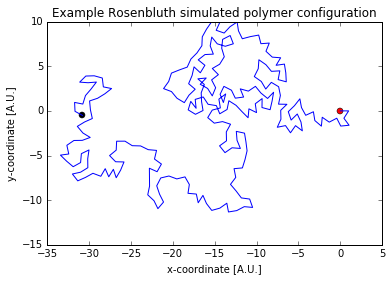

In [139]:
# Plot of the last created polymer with the Rosenbluth Method
%pylab inline
plt.title('Example Rosenbluth simulated polymer configuration')
plt.xlabel('x-coordinate [A.U.]')
plt.ylabel('y-coordinate [A.U.]')
plt.plot(pos[0,0],pos[0,1],'ro')
plt.plot(pos[N-1,0],pos[N-1,1],'ko')
plt.plot(pos[:,0],pos[:,1])
plt.savefig('polymer4.eps', format='eps', dpi=1200)

In [79]:
def P_Extend(cn, PolWeight):
    
    # Sometimes all angles result in 0 weight, in that case this function is repeated.
    succes = 0
    while succes == 0:
        
        weight, angle = getweight(NA, cn)
        W = np.sum(weight)
        
        # If there is a non-zero weight, we end the loop, select and set the location for the monomer.
        if W != 0:
            succes = 1
            
            p = random.random()
            wsum = np.cumsum(weight / W)
            for j in range(NA):
                if p <= wsum[j]:
                    pos[cn, :] = pos[cn-1, :] + angle[j, :]
                    break
                    
            # We update the Polymer Weight, the average weight and increase the population size for the current polymer length.
            PolWeight[cn] = 1.3333*PolWeight[cn-1] * W/NA
            SumWeight[cn] += PolWeight[cn]
            PopSize[cn] += 1
            
            # If the current monomer (cn) has not completed the chain, recursively add another and consider enriching/pruning.
            if cn < N-1:
                # Determine enriching/pruning conditions.
                UpLim = 2*SumWeight[cn] / SumWeight[2]
                LowLim = 1.2*SumWeight[cn] / SumWeight[2]
                
                # Enriching
                if PolWeight[cn] > UpLim:
                    P_Extend(cn+1, 0.5*PolWeight)
                    P_Extend(cn+1, 0.5*PolWeight)
                
                # Pruning
                elif PolWeight[cn] < LowLim:
                    if random.random() < 0.5:
                        P_Extend(cn+1, 2*PolWeight)
                        
                    # If the polymer is ended by Pruning, we want to calculate the weighted End-to-End distance,
                    # the total weight for averaging. The Polymer number is increased since we move on to the next polymer.
                    else:
                        R2W[2:cn+1] += (pos[2:cn+1, 0]**2 + pos[2:cn+1, 1]**2) * PolWeight[2:cn+1]
                        deviation[2:cn+1, PolNumber[0]] = (pos[2:cn+1, 0]**2 + pos[2:cn+1, 1]**2) * PolWeight[2:cn+1]
                        AWeight[2:cn+1] += PolWeight[2:cn+1]
                        PolNumber[0] += 1
                # If the polymer is not enriched or pruned, it just grows on.        
                else:
                    P_Extend(cn+1, PolWeight)
                               
            # If the polymer is fully grown, we want to calculate the weighted End-to-End distance,
            # the total weight for averaging. The Polymer number is increased since we move on to the next polymer.        
            else:
                R2W[2:cn+1] += (pos[2:cn+1, 0]**2 + pos[2:cn+1, 1]**2) * PolWeight[2:cn+1]
                AWeight[2:cn+1] += PolWeight[2:cn+1]
                deviation[2:cn+1, PolNumber[0]] = (pos[2:cn+1,0]**2 + pos[2:cn+1,1]**2) * PolWeight[2:cn+1]
                PolNumber[0] += 1
    return       

In [80]:
R2W = np.zeros(N, dtype='float')
PopSize   = np.zeros(N, dtype='int')
PopSize[0:2] = NP
SumWeight = np.zeros(N, dtype='float')
AWeight   = np.zeros(N, dtype='float')
PolNumber = np.zeros(1, dtype='int')
deviation = np.zeros((N,300*NP), dtype='float') # Should be large enough to contain all polymers, even the pruned.
error_P   = np.zeros(N, dtype = 'float')

# We create NP polymers, although the actual amount of polymers fluctuates due to pruning and enriching
for q in range(NP):
    PolWeight= np.zeros(N, dtype='float')
    PolWeight[0:2] = 1
    pos = np.zeros((N+1, 2),dtype='float')      # Contains the position of each monomer making the polymer.
    pos[1,:] = [1, 0]                           # The first 2 monomers are set manually.
    cn = 2                                      # The current monomere or 'node' is set at 2 (that's the third monomer)
    P_Extend(cn, PolWeight)

R2_P = np.zeros(N, dtype='float')
R2_P[2:N+1] = R2W[2:N+1] / AWeight[2:N+1]       #The Weighted End-to-End distance is averaged using the total weight.           
R2_P[0] = 0
R2_P[1] = 1

# Error for each monomer length using the square root law. Since not all polymers are of equal length,
# only filled distances should be taken into account.
for i in range(2,N):
    NonZero = np.nonzero(deviation[i,:])
    error_P[i] = np.sqrt(np.sum((deviation[i,NonZero]-mean(deviation[i,NonZero]))**2)/AWeight[i]) / sqrt(PopSize[i])

In [81]:
# Function type for fitting.
def fit(x, a, v):
    return a*(x-1)**v

In [89]:
# Fitting using the least squares method, a fitline is calculated to be plotted.
guess = [1, 1.5]
popt, pcov = curve_fit(fit, linspace(1,N,N), R2_P, guess)
print('The fit parameter are: a =',popt[0], 'and v =',popt[1])
fitline = fit(linspace(1,N,N), popt[0],popt[1])

The fit parameter are: a = 0.717313543738 and v = 1.51633445798


Populating the interactive namespace from numpy and matplotlib


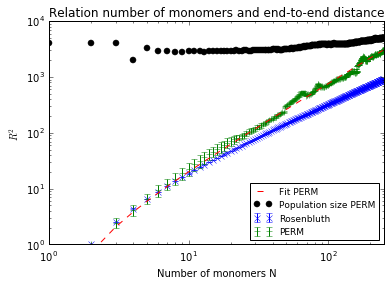

In [83]:
# Plotting the simulation results
%pylab inline
ax = plt.gca() 
plt.title('Relation number of monomers and end-to-end distance')
plt.xlabel('Number of monomers N')
plt.ylabel('$R^2$')
plt.yscale('log')
plt.xscale('log')
ax.set_xlim([1,250])
ax.set_ylim([1,10**4])


plt.errorbar(linspace(1,N,N),R2_R,error_R,fmt='x',label='Rosenbluth')
plt.errorbar(linspace(1,N,N),R2_P,error_P,fmt='+', label='PERM')
plt.plot(linspace(1,N,N),fitline,'--',label='Fit PERM')
plt.plot(linspace(1,N,N),PopSize,'ko',label='Population size PERM')
plt.legend(loc=4,prop={'size':9})
plt.savefig('all_plot_4000.eps', format='eps', dpi=1200)
